In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from census import Census
from us import states

import ipdb

# Data Processing
## Including land use data *and* trip data (OD)

In [2]:
# trip data -> OD

In [3]:
# # land use and Census data
# ## path of the data offered by Han Wang
# path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/HW - EPCs_ACS2018_tbl.csv'
# demographic_result = pd.read_csv(path)
# demographic_result.T

In [4]:
# Access shapefile of California census tracts, 06 represents CA
# Census tracts data 只到tract level，但是smart location data到了census block group level
# 所以smart location data更细
ca_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
ca_tract = ca_tract
ca_tract = ca_tract[['GEOID', 'geometry', 'INTPTLAT', 'INTPTLON']]
# ca_tract.plot()

In [5]:
# smart location data url: https://www.epa.gov/smartgrowth/smart-location-database-technical-documentation-and-user-guide
sl_path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/Smart Location Data Export.csv'
sl_data = pd.read_csv(sl_path)[[
    'OBJECTID', 'GEOID20', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]]

In [6]:
sl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220739 entries, 0 to 220738
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   OBJECTID     220739 non-null  int64  
 1   GEOID20      220739 non-null  int64  
 2   CSA          167709 non-null  float64
 3   CSA_Name     167709 non-null  object 
 4   CBSA         203645 non-null  float64
 5   CBSA_Name    203645 non-null  object 
 6   AutoOwn0     220739 non-null  int64  
 7   AutoOwn1     220739 non-null  int64  
 8   AutoOwn2p    220739 non-null  int64  
 9   TotEmp       220739 non-null  int64  
 10  E_LowWageWk  220739 non-null  int64  
 11  E_MedWageWk  220739 non-null  int64  
 12  E_HiWageWk   220739 non-null  int64  
 13  D1B          220739 non-null  float64
 14  D1C          220739 non-null  float64
 15  D3A          220739 non-null  float64
 16  D4A          220739 non-null  float64
 17  D4B050       220739 non-null  float64
 18  D4C          220739 non-

In [7]:
sl_data['GEOID'] = sl_data['GEOID20'] // 10
sl_data['COUNTYID'] = sl_data['GEOID20'] // 1e7

In [8]:
ca_tract['TotPop'] = ''
for i in ca_tract.index:
    geoid = int(ca_tract.loc[i, 'GEOID'])
    ca_tract.loc[i, 'TotPop'] = sl_data.loc[sl_data['GEOID']==geoid, 'TotPop'].sum()

In [9]:
def add_att(att, type_):
    # type_ can be 'sum', 'mean' or 'same'
    ca_tract[att] = ''
    for i in ca_tract.index:
        geoid = int(ca_tract.loc[i, 'GEOID'])
        if type_ == 'sum':
            ca_tract.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].sum()
        elif type_ == 'mean':
            ca_tract.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].mean()
        elif type_ == 'same':
            ca_tract.loc[i, att] = sl_data.loc[sl_data['GEOID']==geoid, att].iloc[0]
            

In [10]:
att_lst = [
    'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p',\
    'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1B', 'D1C', 'D3A', 'D4A', 'D4B050', 'D4C', 'D4D', \
    'D5AR', 'D5AE', 'NatWalkInd', 'TotPop'
]

type_lst = [
    'same', 'same', 'same', 'same', 'sum', 'sum', 'sum',\
    'sum', 'sum', 'sum', 'sum', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean', 'mean',\
    'sum', 'sum', 'mean', 'sum'
]

assert(len(att_lst) == len(type_lst))

In [11]:
# may spend around 1.5 minutes
for i in range(len(att_lst)):
#     print(i)
    add_att(att_lst[i], type_lst[i])

In [12]:
for i in ca_tract.index:
    ca_tract.loc[i, 'COUNTYID'] = ca_tract.loc[i, 'GEOID'][:5]

att_lst.append('COUNTYID')
att_lst.append('GEOID')
type_lst.append('same')
type_lst.append('same')

In [13]:
ca_tract.head(2)

GEOID                                           geometry  \
0  06037139301  POLYGON ((-118.57150 34.17758, -118.57148 34.1...   
1  06037139302  POLYGON ((-118.54073 34.18019, -118.54070 34.1...   

      INTPTLAT      INTPTLON TotPop    CSA                    CSA_Name  \
0  +34.1781538  -118.5581265   4590  348.0  Los Angeles-Long Beach, CA   
1  +34.1767230  -118.5383655   5549  348.0  Los Angeles-Long Beach, CA   

      CBSA                           CBSA_Name AutoOwn0  ...        D1C  \
0  31080.0  Los Angeles-Long Beach-Anaheim, CA       22  ...    1.69166   
1  31080.0  Los Angeles-Long Beach-Anaheim, CA      236  ...  10.444677   

         D3A         D4A    D4B050        D4C        D4D    D5AR    D5AE  \
0  20.584907  791.706667   0.57606  13.113333   36.26638  676676  565943   
1  20.153137      386.24  0.955044      8.335  127.53158  507768  428507   

  NatWalkInd COUNTYID  
0  13.333333    06037  
1       12.5    06037  

[2 rows x 27 columns]

In [14]:
sl_data.head(2)

OBJECTID       GEOID20    CSA                  CSA_Name     CBSA  \
0         1  481130078254  206.0  Dallas-Fort Worth, TX-OK  19100.0   
1         2  481130078252  206.0  Dallas-Fort Worth, TX-OK  19100.0   

                         CBSA_Name  AutoOwn0  AutoOwn1  AutoOwn2p  TotEmp  \
0  Dallas-Fort Worth-Arlington, TX        69        39        315      66   
1  Dallas-Fort Worth-Arlington, TX         0       168        241      25   

   ...     D4A    D4B050   D4C        D4D    D5AR    D5AE  NatWalkInd  TotPop  \
0  ...  362.10  0.000000  4.33  37.654717  433601  303660   14.000000    1202   
1  ...  718.84  0.009516  4.33  23.126113  386504  272135   10.833333     710   

         GEOID  COUNTYID  
0  48113007825   48113.0  
1  48113007825   48113.0  

[2 rows x 26 columns]

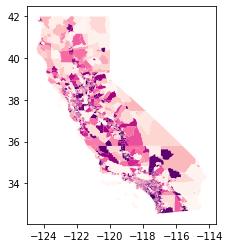

In [15]:
# Create subplots
fig = plt.figure()
ax = fig.add_subplot(111)

im = ca_tract.plot(column = 'TotPop', cmap='RdPu', ax=ax)
# fig.savefig('cal.svg', format='svg')

In [16]:
from shapely.ops import unary_union

def get_county_data():
    # 新建一个表格，找出各个county的数据（通过合并各个county的tract来实现）
    county_lst = ca_tract['COUNTYID'].drop_duplicates()  # datatype: series
    col_ = ['TotPop', 'COUNTYID', 'geometry']
    county_data = gpd.GeoDataFrame(columns=col_, index=range(len(county_lst)))
    
    for i in range(len(county_lst)):
        this_county_id = county_lst.iloc[i]
        this_county = ca_tract[ca_tract['COUNTYID']==this_county_id]
        polygons = this_county['geometry']
        boundary = gpd.GeoSeries(unary_union(polygons))
        
        county_data.loc[i, 'geometry'] = boundary.values
        county_data.loc[i, 'COUNTYID'] = this_county_id
        county_data.loc[i, 'TotPop'] = this_county['TotPop'].sum()
        
    return county_data

In [17]:
ca_county = get_county_data()

<AxesSubplot:>

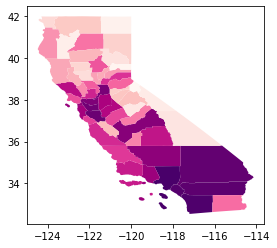

In [18]:
# Create subplots
fig = plt.figure()
ax = fig.add_subplot(111)

ca_county.plot(column = 'TotPop', cmap='RdPu', ax=ax)

## Landuse data (Smart Location)

In [19]:
def plot_area_by_pop(CBSA):
    # plot an area by population, input: CBSA name
    temp = ca_tract.loc[ca_tract['CBSA_Name']==CBSA]
    fig = plt.figure(figsize=[10,20])
    ax = fig.add_subplot(111)
    temp.plot(ax=ax, column='TotPop', cmap='RdPu')
    return fig

In [20]:
# fig = plot_area_by_pop('San Francisco-Oakland-Berkeley, CA')
# fig.savefig('bay_area.svg', format='svg')

In [21]:
station_coor = pd.read_csv(
    '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/station-coor.csv', index_col=0
)
station_coor.head(2)

abbr        lat         lon
0  12TH  37.803768 -122.271450
1  16TH  37.765062 -122.419694

In [22]:
ca_tract[['INTPTLAT', 'INTPTLON']] = ca_tract[['INTPTLAT', 'INTPTLON']].astype(float)
ca_tract

GEOID                                           geometry  \
0     06037139301  POLYGON ((-118.57150 34.17758, -118.57148 34.1...   
1     06037139302  POLYGON ((-118.54073 34.18019, -118.54070 34.1...   
2     06037139502  POLYGON ((-118.53225 34.16201, -118.53177 34.1...   
3     06037139600  POLYGON ((-118.51858 34.15858, -118.51858 34.1...   
4     06037139701  POLYGON ((-118.50980 34.15691, -118.50848 34.1...   
...           ...                                                ...   
8052  06001443001  POLYGON ((-121.95760 37.52392, -121.95745 37.5...   
8053  06001443002  POLYGON ((-121.96900 37.52248, -121.96885 37.5...   
8054  06001443102  POLYGON ((-121.93952 37.51476, -121.93926 37.5...   
8055  06001443301  POLYGON ((-121.92094 37.47505, -121.92092 37.4...   
8056  06037137501  POLYGON ((-118.58837 34.16640, -118.58826 34.1...   

       INTPTLAT    INTPTLON TotPop    CSA                            CSA_Name  \
0     34.178154 -118.558127   4590  348.0          Los Angeles-Long Beach, CA   
1     34.176723 -118.538365   5549  348.0          Los Angeles-Long Beach, CA   
2     34.162840 -118.526311   2856  348.0          Los Angeles-Long Beach, CA   
3     34.164060 -118.510100   4803  348.0          Los Angeles-Long Beach, CA   
4     34.157429 -118.495412   5336  348.0          Los Angeles-Long Beach, CA   
...         ...         ...    ...    ...                                 ...   
8052  37.518422 -121.951524   3046  488.0  San Jose-San Francisco-Oakland, CA   
8053  37.516834 -121.960592   6745  488.0  San Jose-San Francisco-Oakland, CA   
8054  37.507224 -121.927149   4881  488.0  San Jose-San Francisco-Oakland, CA   
8055  37.470732 -121.912956   4343  488.0  San Jose-San Francisco-Oakland, CA   
8056  34.164934 -118.576804   4516  348.0          Los Angeles-Long Beach, CA   

         CBSA                           CBSA_Name AutoOwn0  ...        D1C  \
0     31080.0  Los Angeles-Long Beach-Anaheim, CA       22  ...    1.69166   
1     31080.0  Los Angeles-Long Beach-Anaheim, CA      236  ...  10.444677   
2     31080.0  Los Angeles-Long Beach-Anaheim, CA       25  ...   3.795625   
3     31080.0  Los Angeles-Long Beach-Anaheim, CA       70  ...   8.358791   
4     31080.0  Los Angeles-Long Beach-Anaheim, CA       69  ...  15.211208   
...       ...                                 ...      ...  ...        ...   
8052  41860.0  San Francisco-Oakland-Berkeley, CA       10  ...   0.733511   
8053  41860.0  San Francisco-Oakland-Berkeley, CA       26  ...   0.874175   
8054  41860.0  San Francisco-Oakland-Berkeley, CA       28  ...   0.598466   
8055  41860.0  San Francisco-Oakland-Berkeley, CA       10  ...   0.474837   
8056  31080.0  Los Angeles-Long Beach-Anaheim, CA       77  ...   9.418832   

            D3A         D4A    D4B050        D4C        D4D     D5AR     D5AE  \
0     20.584907  791.706667   0.57606  13.113333   36.26638   676676   565943   
1     20.153137      386.24  0.955044      8.335  127.53158   507768   428507   
2     23.935872      435.19       0.0        8.0  39.651604   450585   377949   
3      17.94273     549.185       0.0     10.665  22.432592   512374   427511   
4     17.929219   -19738.82       0.0     11.732  56.227418  1536142  1277774   
...         ...         ...       ...        ...        ...      ...      ...   
8052  24.889144      493.53  0.006533       4.33  14.588858   161233   133083   
8053  30.534006      654.47       0.0        4.0  21.465629   532376   419094   
8054  25.924359    537.1175  0.116977     4.5825  21.915142   596942   498701   
8055  28.121929       498.9       0.0        4.0  18.328927   337078   279812   
8056  22.154216      824.79       0.0      6.335  17.525423   425093   349270   

     NatWalkInd COUNTYID  
0     13.333333    06037  
1          12.5    06037  
2     16.583333    06037  
3     16.083333    06037  
4     13.633333    06037  
...         ...      ...  
8052  13.666667    06001  
8053  14.055556    06001  
8054  13.166667    06

In [23]:
# to drop distant (from any stations) areas
# interate each station, drop distant tract from ca_tract

dist_lmt = 0.05
print('The catchment radius is around %.3f km, %.3f mile'%(dist_lmt*111, dist_lmt*111/1.6))

ca_tract['if_keep'] = np.nan
ca_tract['nearest station'] = np.nan
ca_tract['transit distance [km]'] = 10000
att_lst.extend(['if_keep', 'nearest station', 'transit distance [km]', 'INTPTLAT', 'INTPTLON'])
type_lst.extend(['same', 'same', 'mean', 'mean', 'mean'])  # 'transit distance [km]' is useless after mean


for i in station_coor.index:
    station_lat = station_coor.loc[i, 'lat']
    station_lon = station_coor.loc[i, 'lon']
    station_name = station_coor.loc[i, 'abbr']
    
    dist_df_temp = np.sqrt((ca_tract['INTPTLAT'] - station_lat)**2 + (ca_tract['INTPTLON'] - station_lon)**2)

    ca_tract.loc[dist_df_temp < dist_lmt, 'if_keep'] = 1
    for j in ca_tract.loc[ca_tract['if_keep']==1].index:
        currrent_dist = dist_df_temp.loc[j]
        if ca_tract.loc[j, 'transit distance [km]'] > currrent_dist*111:  # 假如遇到了更近的站
            ca_tract.loc[j, 'transit distance [km]'] = currrent_dist*111
            ca_tract.loc[j, 'nearest station'] = station_name
    

The catchment radius is around 5.550 km, 3.469 mile


<AxesSubplot:>

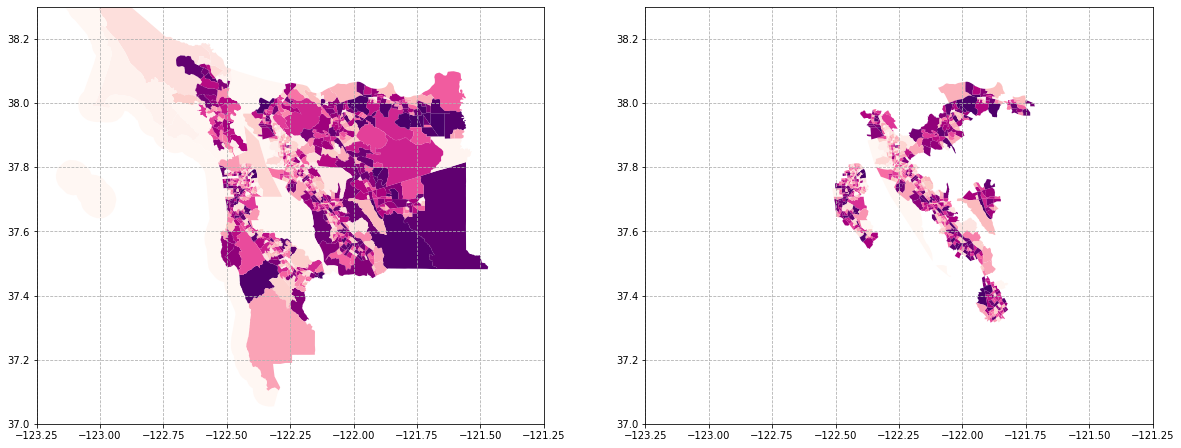

In [24]:
ca_tract_nearbart = ca_tract.loc[ca_tract['if_keep']==1]
fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_xlim([-123.25, -121.25])
ax1.set_ylim([37, 38.3])
ax1.grid(ls='--')
ax2.set_xlim([-123.25, -121.25])
ax2.set_ylim([37, 38.3])
ax2.grid(ls='--')

ca_tract.loc[ca_tract['CBSA_Name']=='San Francisco-Oakland-Berkeley, CA'].plot(column='TotPop', ax=ax1, cmap='RdPu')
ca_tract_nearbart.plot(column='TotPop', ax=ax2, cmap='RdPu')


<AxesSubplot:>

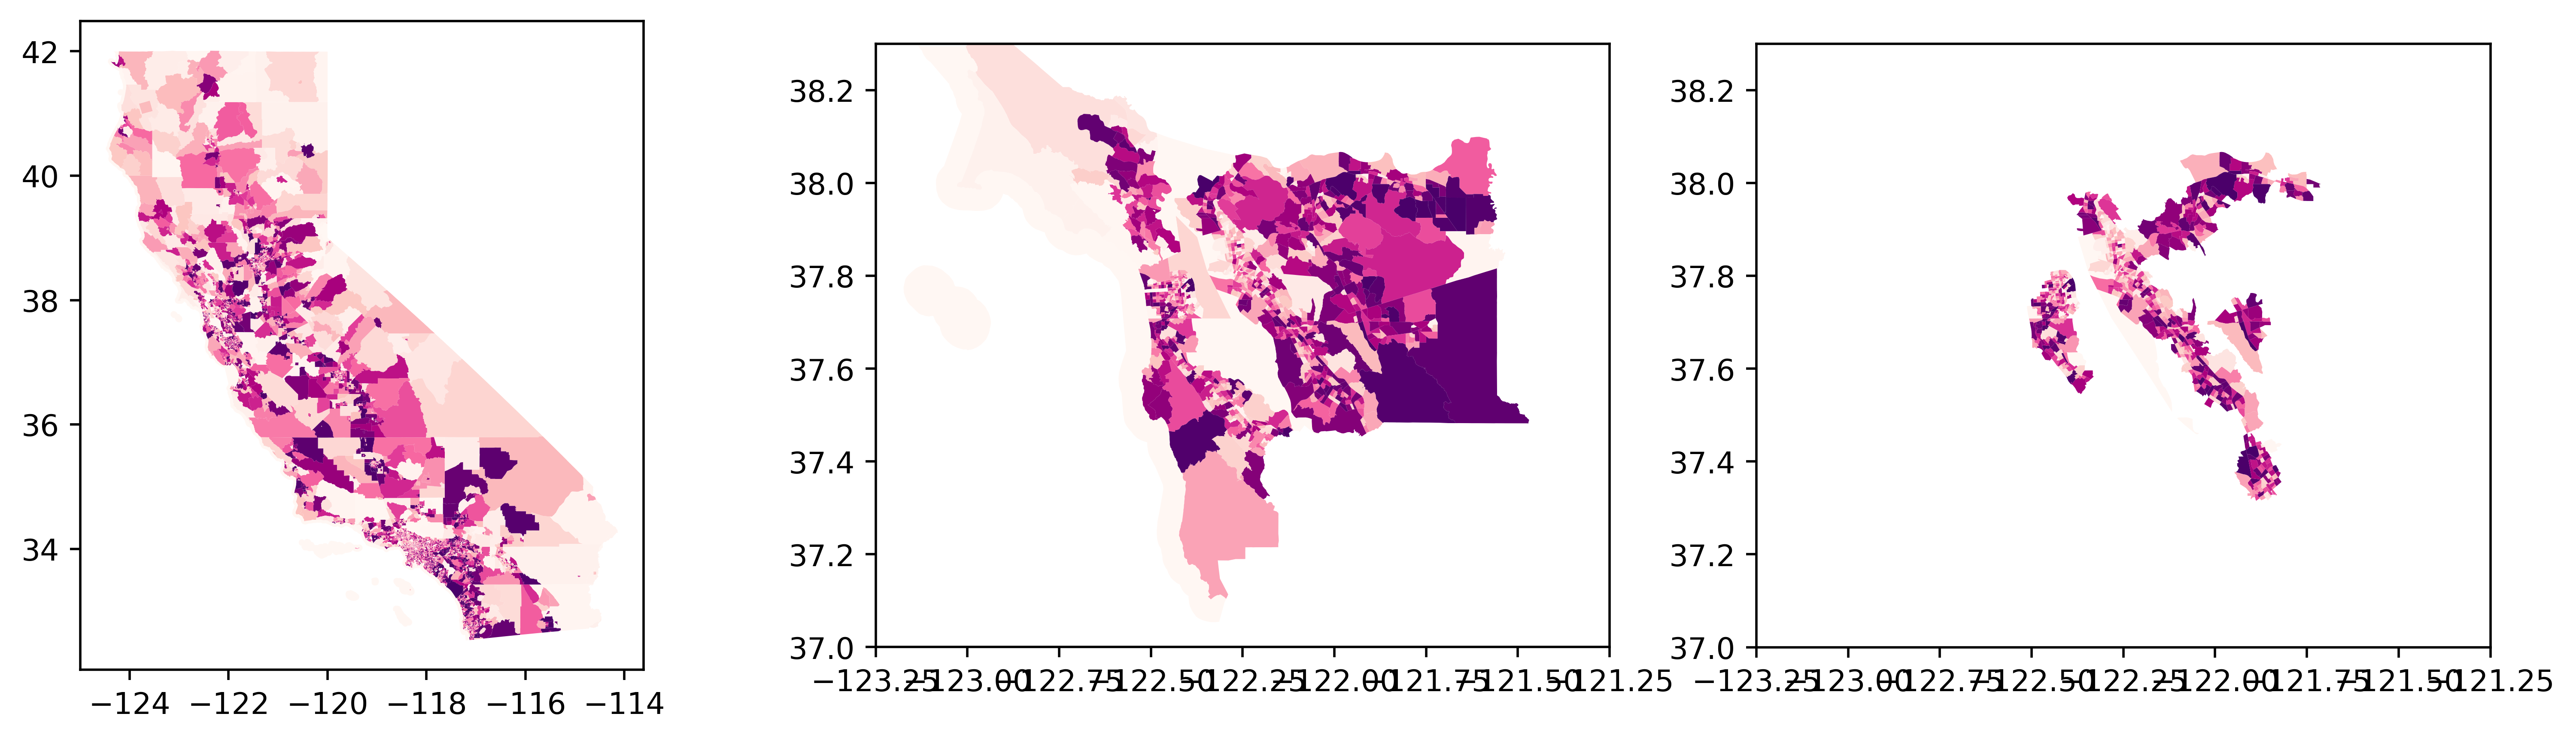

In [25]:
# For write up for data
fig = plt.figure(figsize=[15, 4], dpi=500)
ax0 = fig.add_subplot(131)


im = ca_tract.plot(column = 'TotPop', cmap='RdPu', ax=ax0)
# fig.savefig('cal.svg', format='svg')

ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
ax1.set_xlim([-123.25, -121.25])
ax1.set_ylim([37, 38.3])
ax2.set_xlim([-123.25, -121.25])
ax2.set_ylim([37, 38.3])

ca_tract.loc[ca_tract['CBSA_Name']=='San Francisco-Oakland-Berkeley, CA'].plot(column='TotPop', ax=ax1, cmap='RdPu')
ca_tract_nearbart.plot(column='TotPop', ax=ax2, cmap='RdPu')

In [26]:
ca_tract_nearbart.head(2)

GEOID                                           geometry   INTPTLAT  \
6  06013324002  POLYGON ((-122.07313 37.94793, -122.07276 37.9...  37.951498   
8  06013336201  POLYGON ((-122.05390 37.95307, -122.05286 37.9...  37.960462   

     INTPTLON TotPop    CSA                            CSA_Name     CBSA  \
6 -122.060561   5305  488.0  San Jose-San Francisco-Oakland, CA  41860.0   
8 -122.047502   3966  488.0  San Jose-San Francisco-Oakland, CA  41860.0   

                            CBSA_Name AutoOwn0  ... D4B050       D4C  \
6  San Francisco-Oakland-Berkeley, CA      126  ...    0.0  3.446667   
8  San Francisco-Oakland-Berkeley, CA      109  ...    0.0 -33330.89   

            D4D    D5AR    D5AE NatWalkInd COUNTYID if_keep nearest station  \
6     12.072633  321636  288180  16.833333    06013     1.0            PHIL   
8 -33310.783597  258203  236456  12.166667    06013     1.0            CONC   

  transit distance [km]  
6              2.605781  
8              2.519122  

[2 rows x 30 columns]

In [27]:
ca_tract_nearbart.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 739 entries, 6 to 8055
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   GEOID                  739 non-null    object  
 1   geometry               739 non-null    geometry
 2   INTPTLAT               739 non-null    float64 
 3   INTPTLON               739 non-null    float64 
 4   TotPop                 739 non-null    object  
 5   CSA                    739 non-null    object  
 6   CSA_Name               739 non-null    object  
 7   CBSA                   739 non-null    object  
 8   CBSA_Name              739 non-null    object  
 9   AutoOwn0               739 non-null    object  
 10  AutoOwn1               739 non-null    object  
 11  AutoOwn2p              739 non-null    object  
 12  TotEmp                 739 non-null    object  
 13  E_LowWageWk            739 non-null    object  
 14  E_MedWageWk            739 non-nu

In [28]:
# OD matrix follows the stops order as follows
stops = pd.read_csv('/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/stops_order.csv', index_col=0)

In [29]:
# data_X_all means with all attributes
data_X_all = gpd.GeoDataFrame(np.nan, index=range(50), columns=ca_tract_nearbart.columns)
data_X_all['nearest station'] = stops

In [30]:
data_X_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   GEOID                  0 non-null      float64 
 1   geometry               0 non-null      geometry
 2   INTPTLAT               0 non-null      float64 
 3   INTPTLON               0 non-null      float64 
 4   TotPop                 0 non-null      float64 
 5   CSA                    0 non-null      float64 
 6   CSA_Name               0 non-null      float64 
 7   CBSA                   0 non-null      float64 
 8   CBSA_Name              0 non-null      float64 
 9   AutoOwn0               0 non-null      float64 
 10  AutoOwn1               0 non-null      float64 
 11  AutoOwn2p              0 non-null      float64 
 12  TotEmp                 0 non-null      float64 
 13  E_LowWageWk            0 non-null      float64 
 14  E_MedWageWk            0 non-null   

In [31]:
for i in stops.index:
    station = stops.loc[i, 'stop']
    for j in range(len(att_lst)):
        att = att_lst[j]
        type_ = type_lst[j]

        if type_ == 'sum':
            data_X_all.loc[data_X_all['nearest station']==station, att] = \
                ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, att].sum()
        elif type_ == 'mean':
            data_X_all.loc[data_X_all['nearest station']==station, att] = \
                ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, att].mean()
        elif type_ == 'same':
            data_X_all.loc[data_X_all['nearest station']==station, att] = \
                ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, att].iloc[0]

    # union the geometry
    polygons = ca_tract_nearbart.loc[ca_tract_nearbart['nearest station']==station, 'geometry']
    boundary = gpd.GeoSeries(unary_union(polygons))
    
    data_X_all.loc[data_X_all['nearest station']==station, 'geometry'] = boundary.values
    

<AxesSubplot:>

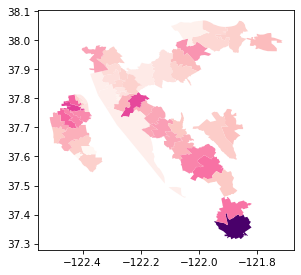

In [32]:
fig = plt.figure(figsize=[15, 5], dpi=75)
ax0 = fig.add_subplot(131)

data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')

In [33]:
# data_X_all.to_file('./data/data_X_all.shp', driver='ESRI Shapefile')

In [34]:
data_X = data_X_all.drop([
    'GEOID', 'geometry', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name',\
    'COUNTYID', 'if_keep', 'transit distance [km]'
], axis=1)

try:
    assert(data_X.shape[1]==21)
except:
    del data_X
    raise Exception('Number of features not correct!')

In [76]:
heat_plot_data_X.corr().head(2)

TotPop  AutoOwn0  AutoOwn1  AutoOwn2p    TotEmp  E_LowWageWk  \
TotPop    1.000000  0.380643  0.783344   0.875263  0.328977     0.571134   
AutoOwn0  0.380643  1.000000  0.761438  -0.054517  0.516173     0.615246   

          E_MedWageWk  E_HiWageWk       D1B       D1C       D3A       D4A  \
TotPop       0.522105    0.221550  0.211295 -0.200680  0.105010  0.294036   
AutoOwn0     0.561949    0.463723  0.825340  0.398325  0.488052  0.324608   

            D4B050       D4C       D4D      D5AR      D5AE  NatWalkInd  
TotPop    0.059003  0.242251  0.241067  0.835494  0.859908    0.194000  
AutoOwn0  0.560615  0.316350  0.323631  0.534180  0.358865    0.460611

In [82]:
heat_plot_data_X.columns.shape

(18,)

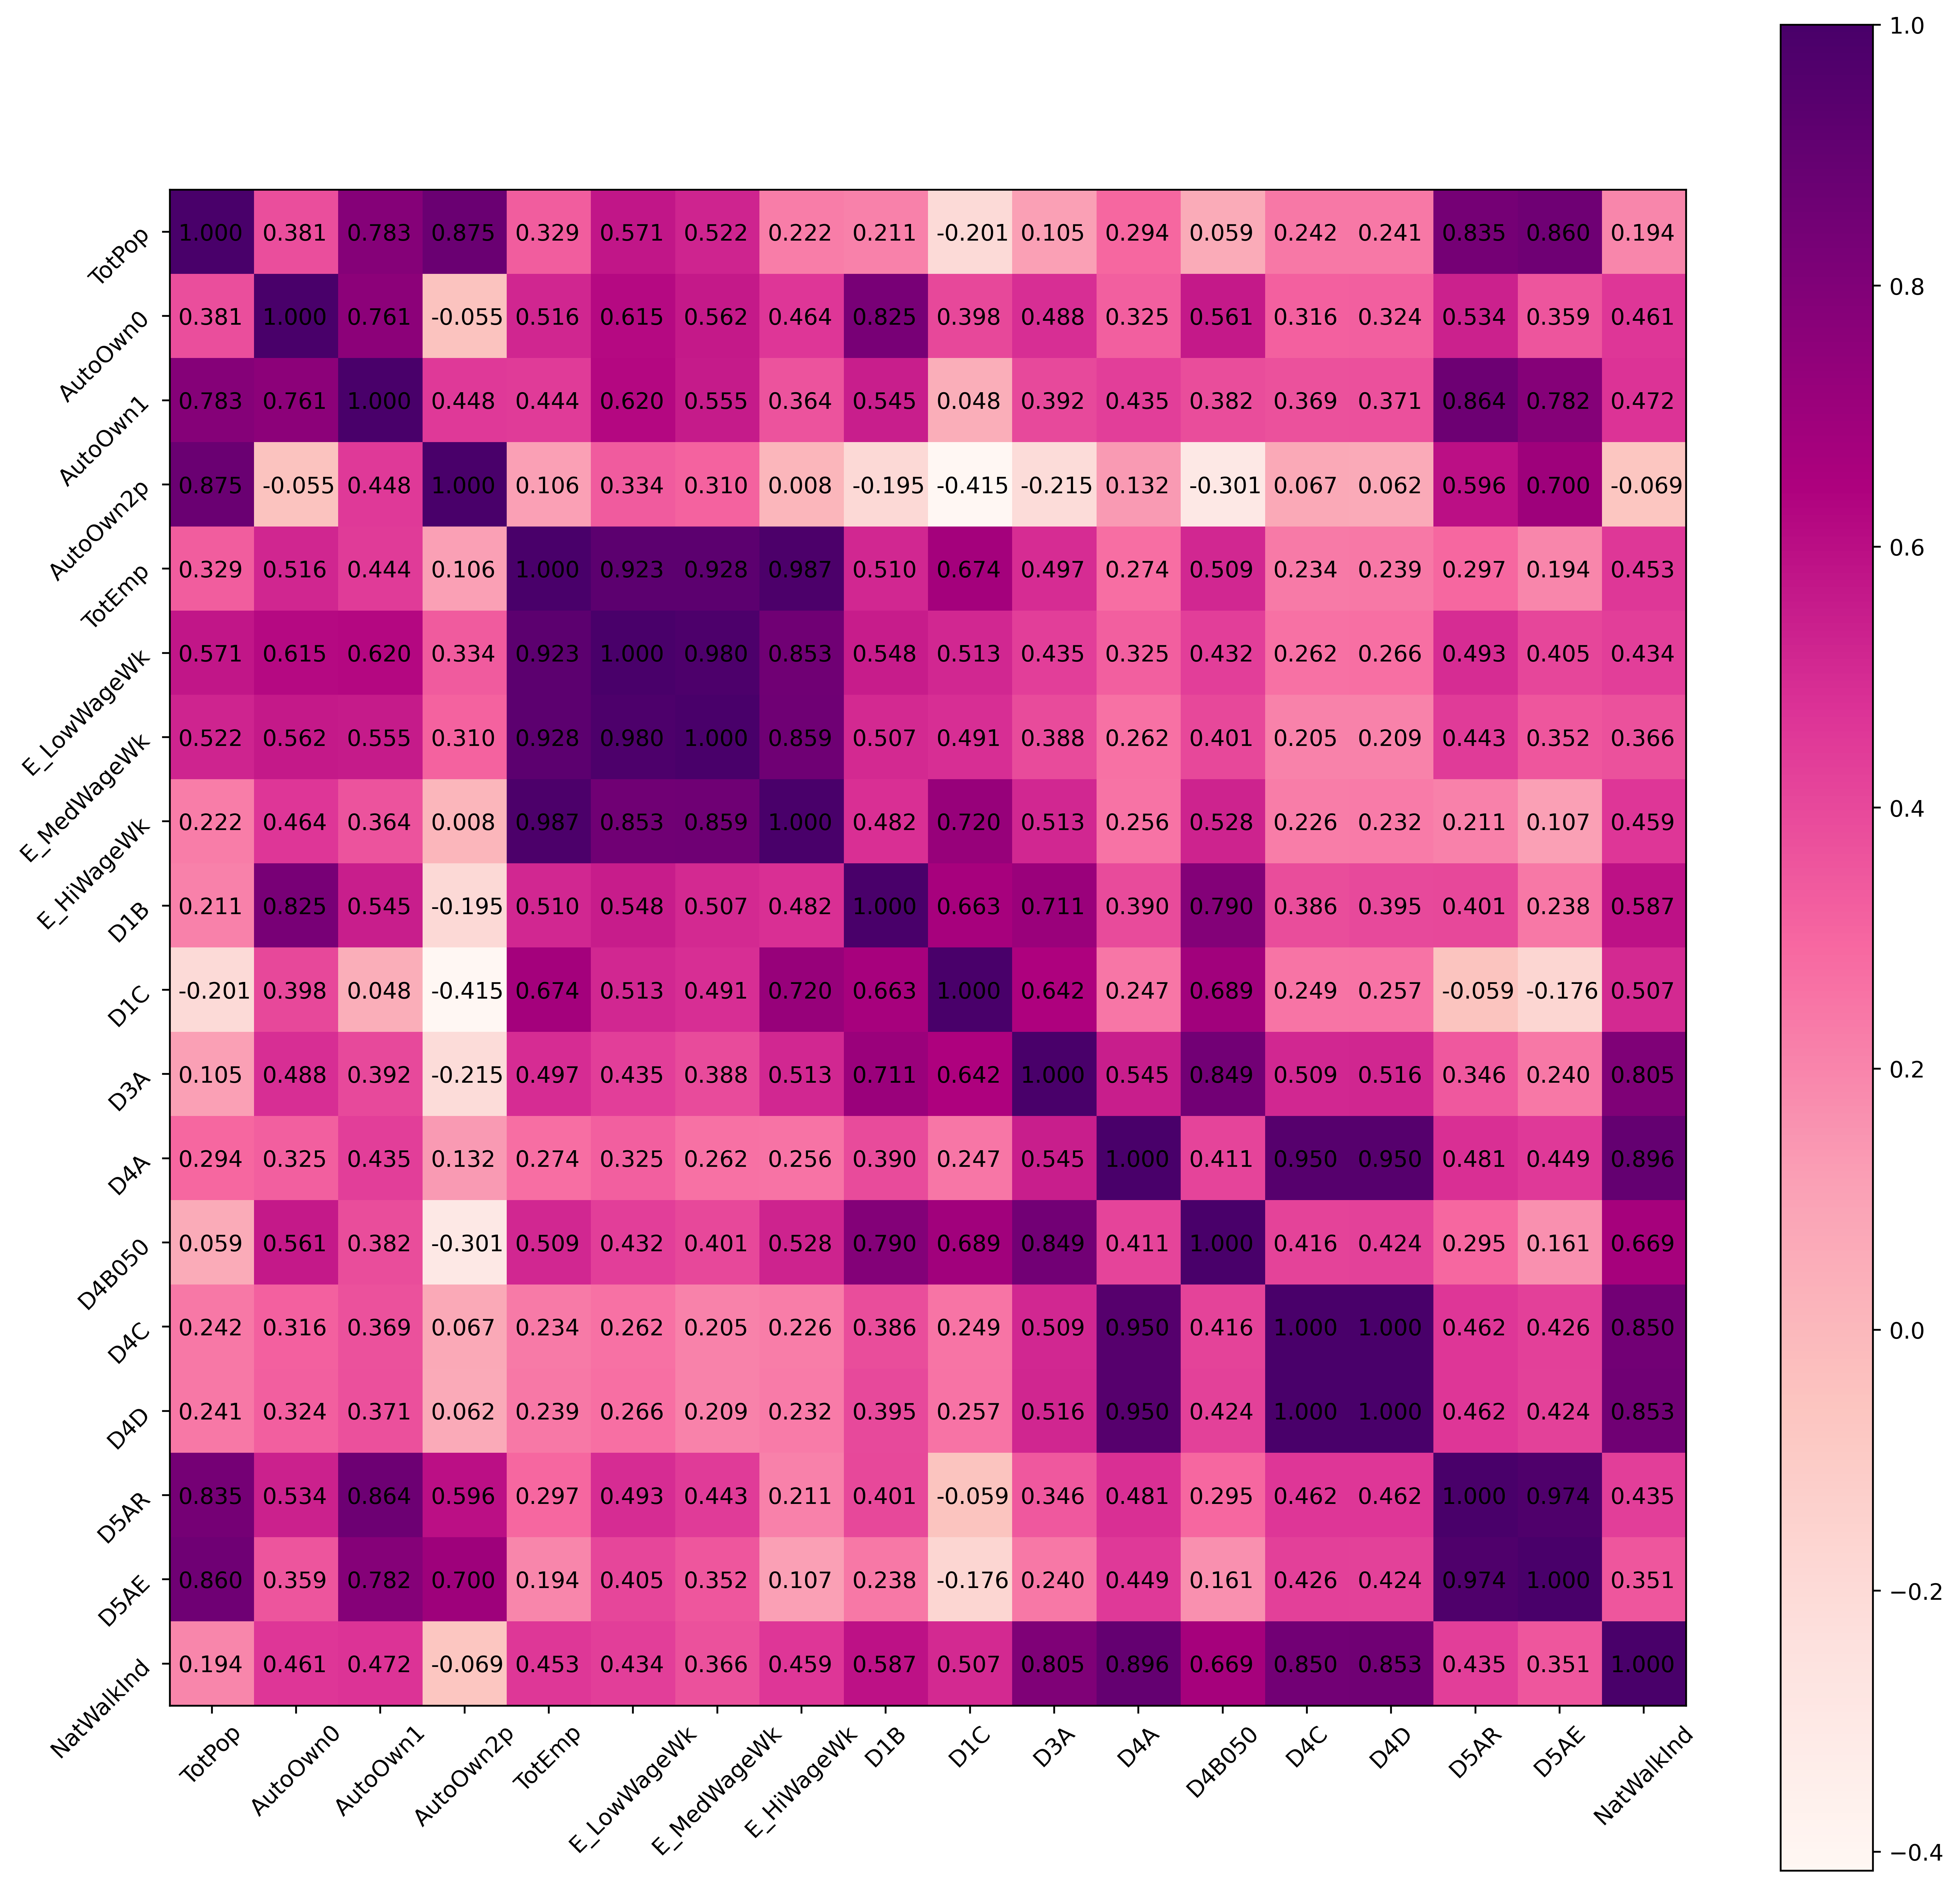

In [86]:
plt.figure(figsize=[15,15], dpi=500)
heat_plot_data_X = data_X.iloc[:, 2:-1]
plt.imshow(heat_plot_data_X.corr(), cmap='RdPu')
for i in range(18):
    for j in range(18):
        plt.text(i-0.4, j+0.1, '%.3f'%(heat_plot_data_X.corr().iloc[i, j]))
plt.xticks(range(18), list(heat_plot_data_X.columns), rotation = 45)
plt.yticks(range(18), list(heat_plot_data_X.columns), rotation = 45)
plt.colorbar()

## Ridership data (BART)
### Processed by file "bart_data.py"

In [37]:
# bart_path_raw = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/date-hour-soo-dest-2019.csv'
# bart_data_raw = pd.read_csv(bart_path_raw, header=None)
# bart_data_raw.shape

# output: (10114285, 5)

In [36]:
# bart_path_4d = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/all.npy'
# bart_data_4d = np.load(file=bart_path_4d)

In [45]:
bart_3d_path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/3d.npy'
bart_data_3d = np.load(file=bart_3d_path)
bart_data_3d.std()

22.72784496612392

In [46]:
# bart_3d_daily = np.zeros([50,50,365])
# for i in range(365):
#     from_ = i*24
#     to_ = (i+1)*24
#     bart_3d_daily[:,:,i] = bart_data_3d[:,:,from_:to_].sum(axis=2)
# np.save(file = '/Volumes/GoogleDrive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/3d_daily.npy', arr = bart_3d_daily)


In [50]:
# Annual data
bart_2d_annual_path = '/Volumes/Google Drive/My Drive/Graduate/SP22 CE 299/data/BART/hour data/2d_annual.npy'
bart_data = np.load(file=bart_2d_annual_path)
bart_data.std()

88725.21157053972

(50, 50)


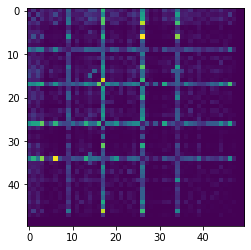

In [39]:
plt.imshow(bart_data)
print(bart_data.shape)

In [46]:
# pd.DataFrame(bart_data, index=stops['stop'].values, columns=stops['stop'].values).to_csv('/Users/kaihangzhang/Downloads/GitHub/Deep_Gravity/data/OD.csv')
